In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import functions as mp
from joblib import Parallel, delayed

import importlib
importlib.reload(mp) # reloads package after changes have been made

<module 'functions' from '/Users/quanle/feature_interactions/functions.py'>

In [2]:
M = 10 
N = 1000
K = 0
J1 = 0 
J2 = 1

SNR = np.linspace(0, 5, 10)

m_ratio = np.sqrt(M) / M
n_ratio = np.sqrt(N) / N
# n_ratio = 1 / 10

B = 1000 # from 1k to 10k
num_trials = 1
models = [
    # MLPRegressor(solver="lbfgs", max_iter=500),
    RandomForestRegressor(n_estimators=50, max_depth=None),
    KernelRidge(alpha=.001, kernel="polynomial", degree=2),
    KernelRidge(alpha=.001, kernel="rbf")
]

In [3]:
def partial_dependence(X, model, S):
    N, M = X.shape
    pd = np.empty(N)
    for i, x in enumerate(X):
        copy = X.copy()
        copy[:, S] = x[S]
        pd[i] = np.mean(model.predict(copy))
    return pd

In [4]:
def f(X, Y, n_ratio, m_ratio, B, model, J1, J2, metric): 
    ensemble = mp.Ensemble(model).fit(X, Y, n_ratio, m_ratio, B)
    predictions = ensemble.predict(X)
    r12, r1, r2, r = mp.computeDeltaCap(Y, J1, J2, 
                                        predictions,
                                        ensemble.mp_observations, 
                                        ensemble.mp_features, 
                                        metric=metric)

    deltas = [r1 + r2 - r12 - r, 
              r12 - r,
              r1 - r, 
              r2 - r,
              r12 - r1,
              r12 - r2]

    result = {}
    result["!h_0"] = len(deltas) * [0]
    result["delta"] = len(deltas) * [0]

    for i, delta in enumerate(deltas):
        ci = mp.getCI(delta, alpha=0.1)
        delta_bar = np.mean(delta)
        # result["!h_0"][i] = 1 if (delta_bar + ci < 0) or (delta_bar - ci > 0) else 0
        result["!h_0"][i] = 1 if (delta_bar - ci > 0) else 0
        result["delta"][i] = delta_bar

    result["errors"] = [np.mean(r), np.mean(r1), np.mean(r2), np.mean(r12)]


    # pd1 = partial_dependence(X, ensemble, J1)
    # pd2 = partial_dependence(X, ensemble, J2)
    # pd12 = partial_dependence(X, ensemble, [J1, J2])
    # temp = np.sum(pd12 - pd1 - pd2) ** 2
    # result["H21"] = temp / np.sum(pd12) ** 2
    # result["H22"] = temp / np.sum(np.mean(predictions, axis=1)) ** 2
    return result



def h(M, N, K, n_ratio, m_ratio, B, model, J1, J2, snr): 
    X, Y = mp.kSparseLinearModel(N, M, K)
    # Y += snr * X[:, J1] 
    Y += X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3] + X[:, 4]
    # Y += (X[:, 1] * X[:, 2]) + (X[:, 2] * X[:, 3]) + (X[:, 3] * X[:, 4])
    Y += snr * (X[:, J1] * X[:, J2])

    # Y += snr * (X[:, J1] > 0) * (X[:, J2] > 0)
    Y = (Y - np.mean(Y)) / np.std(Y)
    
    return f(X, Y, n_ratio, m_ratio, B, model, J1, J2, np.abs) 

In [5]:

residuals   = np.empty((len(SNR), 4, len(models)))
powers      = np.empty((len(SNR), 6, len(models)))
errors      = np.empty((len(SNR), 6, len(models)))
importance  = np.empty((len(SNR), 6, len(models)))
# H2          = np.empty((len(SNR), 2, len(models)))
# H2err       = np.empty((len(SNR), 2, len(models)))

for i, snr in enumerate(SNR):
    results = Parallel(n_jobs=-1)(
              delayed(h)(M, N, K, n_ratio, m_ratio, B, model, J1, J2, snr) 
              for i in range(num_trials) for model in models)

    
    for j, model in enumerate(models):
        result = results[j::len(models)]
        
        null_rejection = np.array([r["!h_0"] for r in result])
        residual = np.array([r["errors"] for r in result])

        errors[i, :, j] = np.std(null_rejection, axis = 0)
        powers[i, :, j] = np.mean(null_rejection, axis = 0)
        residuals[i, :, j] = np.mean(residual, axis = 0)
        importance[i, :, j] = np.mean([r["delta"] for r in result], axis = 0)

        # for k, hmetric in enumerate(["H21", "H22"]):
        #     h2results = np.array(r[hmetric] for r in result)
        #     H2[i, k, j] = np.mean(h2results)
        #     H2err[i, k, j] = np.std(h2results)

        

    print(f"\rfinished run {i} {snr}", end="")

finished run 9 5.0444444444444453

In [6]:
importance.shape

(10, 6, 3)

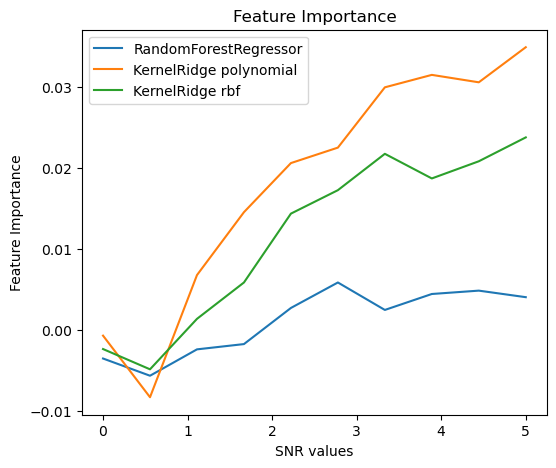

In [7]:
model_names = [model.__class__.__name__ if model.__class__.__name__ != KernelRidge.__name__ else model.__class__.__name__ + " " + model.get_params()["kernel"]
               for model in models]

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

for j, model_name in enumerate(model_names):   
    ax1.plot(SNR, importance[:, 0, j])
    # ax1.plot(SNR, importance[:, 2, j] + importance[:, 3, j] - importance[:, 1, j])
    

ax1.set_title("Feature Importance")
ax1.set_xlabel("SNR values")
ax1.set_ylabel(f"Feature Importance")
ax1.legend(model_names)

plt.show()


In [8]:
import ML_models
import LOCO_regression as loco

LEFT = 2
RIGHT = 3
SQ = 0
ABS = 4
LG = 8

def g(X, Y, n_ratio, m_ratio, B, model, J1, J2, snr): 

    lgcr = loco.LOCOMPReg(X, Y, n_ratio, m_ratio, B, ML_models.DecisionTreeReg, selected_features=[J1, J2], alpha=0.1, bonf=False)
    ress = lgcr["info"]

    result = {}
    ci = lgcr["loco_ci"]

    # result["!h_0"] = [0, *[(1 if ci[i][LEFT] > 0 or ci[i][RIGHT] < 0 else 0) for i in [J1, J2]], 0]
    result["!h_0"] = [0, *[(1 if ci[i][LEFT] > 0 else 0) for i in [J1, J2]], 0]
    result["delta"] = [0, *[(ci[i][LEFT] + ci[i][RIGHT]) / 2 for i in [J1, J2]], 0]
    result["errors"] = [0,
                        np.mean(ress["resid_loco"][ress.j == J1]), 
                        np.mean(ress["resid_loco"][ress.j == J2]), 
                        np.mean(ress["resid_loo"])]

    return result

In [9]:
def fg(M, N, K, n_ratio, m_ratio, B, model, J1, J2, snr): 
    X, Y = mp.kSparseLinearModel(N, M, K)
    Y += snr * X[:, J1]
    # Y += snr * (X[:, J1] + X[:, J2])
    # Y += snr * (X[:, J1] * X[:, J2])
    Y = (Y - np.mean(Y)) / np.std(Y)

    return [f(X, Y, n_ratio, m_ratio, B, model, J1, J2, snr, np.square),
            f(X, Y, n_ratio, m_ratio, B, model, J1, J2, snr, np.abs),
            g(X, Y, n_ratio, m_ratio, B, model, J1, J2, snr)]


mp_params = [M, N, K, n_ratio, m_ratio, B, model, J1, J2]

lg_residuals =  np.empty((len(SNR), 4, 3))
lg_powers =     np.empty((len(SNR), 4, 3))
lg_errors =     np.empty((len(SNR), 4, 3))
lg_importance = np.empty((len(SNR), 4, 3))


for i, snr in enumerate(SNR):
    powers = Parallel(n_jobs=-1)(delayed(fg)(*mp_params, snr) for i in range(num_trials))

    for k in range(3):
        power = [p[k] for p in powers]
        null_rejection = np.array([r["!h_0"] for r in power])
        residual = np.array([r["errors"] for r in power])

        lg_errors[i, :, k] = np.std(null_rejection, axis = 0)
        lg_powers[i, :, k] = np.mean(null_rejection, axis = 0)
        lg_residuals[i, :, k] = np.mean(residual, axis = 0)
        lg_importance[i, :, k] = np.mean([r["delta"] for r in power], axis = 0)

TypeError: f() takes 9 positional arguments but 10 were given

(4, 3)


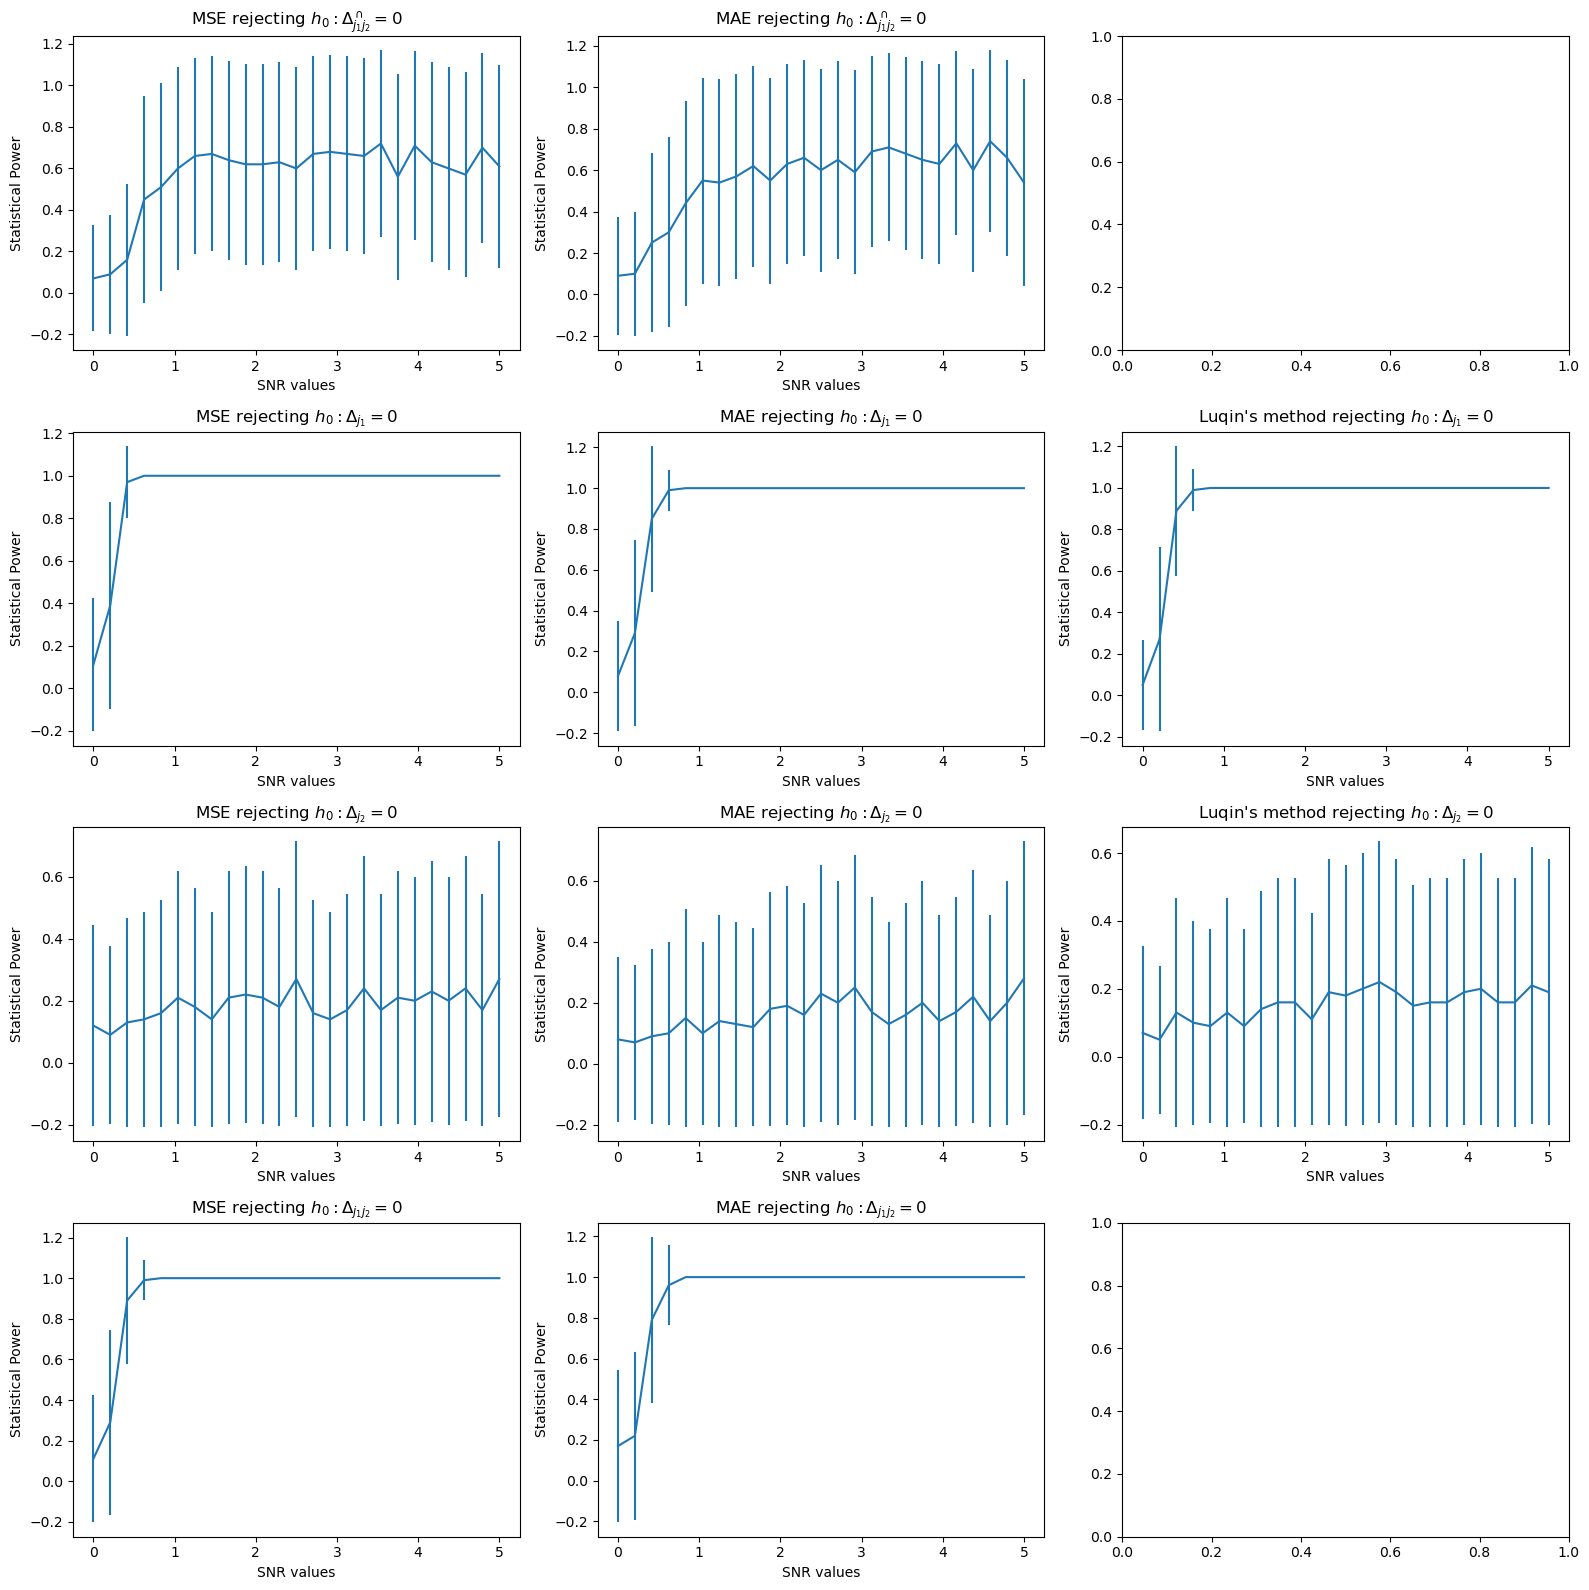

In [ ]:

fig, axss = plt.subplots(4, 3, figsize=(16,16))
titles = ["\Delta^\cap_{j_1j_2}", "\Delta_{j_1}", "\Delta_{j_2}", "\Delta_{j_1j_2}"]

method = ["MSE", "MAE", "Luqin's method"]

print(axss.shape)

for i, axs in enumerate(axss):
    for j, ax in enumerate(axs if i == 1 or i == 2 else axs[:2]):
        ax.errorbar(SNR, lg_powers[:, i, j], yerr = lg_errors[:, i, j])
        ax.set_title(f"{method[j]} rejecting $h_0: {titles[i]} = 0$")
        ax.set_xlabel("SNR values")
        ax.set_ylabel("Statistical Power")

fig.tight_layout()
plt.show()

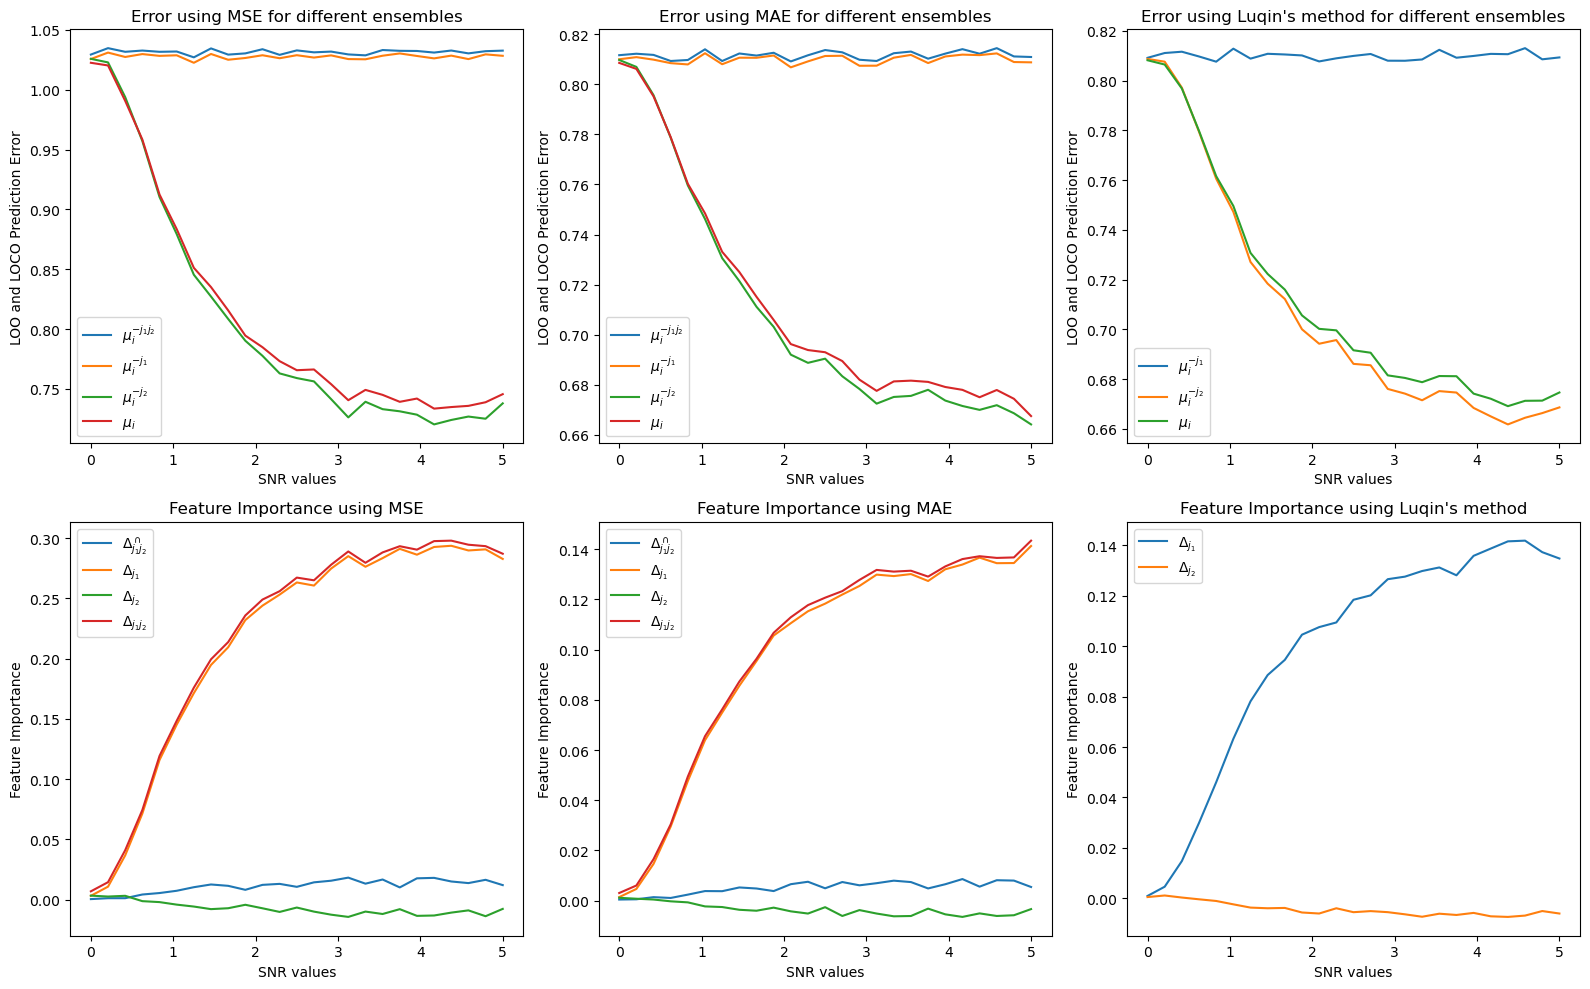

In [ ]:
fig, axss = plt.subplots(2, 3, figsize=(16,10))
method = ["MSE", "MAE", "Luqin's method"]
titles = ["\Delta^\cap_{j_1j_2}", "\Delta_{j_1}", "\Delta_{j_2}", "\Delta_{j_1j_2}"]

mus = ["$\mu_i^{-j_1j_2}$", "$\mu_i^{-j_1}$", "$\mu_i^{-j_2}$", "$\mu_i$"]
titles = [f"${t}$" for t in titles]


for i, axs in enumerate(axss):
    for j, ax in enumerate(axs):
        if (i == 0):
            if (j == 2):
                ax.plot(np.tile(SNR, (3, 1)).T, lg_residuals[:, 1:, j])
                ax.legend(mus[1:])
            else:   
                ax.plot(np.tile(SNR, (4, 1)).T, lg_residuals[:, :, j])
                ax.legend(mus)
            ax.set_xlabel("SNR values")
            ax.set_ylabel("LOO and LOCO Prediction Error")
            ax.set_title(f"Error using {method[j]} for different ensembles")
        else:
            if (j == 2):
                ax.plot(np.tile(SNR, (2, 1)).T, lg_importance[:, 1:3, j])
                ax.legend(titles[1:3]) 
            else:
                ax.plot(np.tile(SNR, (4, 1)).T, lg_importance[:, :, j])
                ax.legend(titles)
            
            ax.set_xlabel("SNR values")
            ax.set_ylabel("Feature Importance")
            ax.set_title(f"Feature Importance using {method[j]}")


fig.tight_layout()
plt.show()

/var/folders/q3/_ggffzj933s64pz_z4jk4ds80000gn/T/ipykernel_1900/2192144352.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  plt.scatter(X1 @ np.linalg.lstsq(X1, Y)[0], Y)


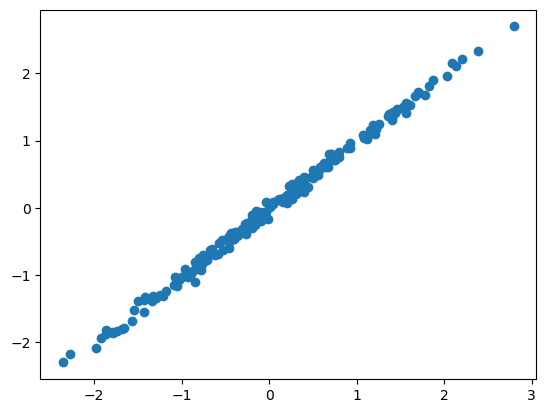

1.0176570004902676
0.8767120885499458
0.8794005549326042
0.7548641815129393


(0.01640853852065701, 0.004936248634223968)

In [ ]:
# single instance verification
snr = 10
K = 0
X, Y = mp.kSparseLinearModel(N, M, K)
Y += snr * (X[:,J1] + X[:,J2])
Y = (Y - np.mean(Y)) / np.std(Y)
# X1 = X[:, [1,2,3,4]]
X1 = X
plt.scatter(X1 @ np.linalg.lstsq(X1, Y)[0], Y)
plt.show()

predictions, mp_observations, mp_features = mp.predict(X, Y, n_ratio, m_ratio, B, model, None)
r = mp.computeDeltaCap(Y, J1, J2, predictions, mp_observations, mp_features)
for v in r:
    print(v.mean())

dc = r[0] - r[1] - r[2] + r[3]
# dc = r[0] - r[3]
ci = mp.getCI(dc, alpha=0.1)
np.mean(dc), ci


In [ ]:
np.tile(SNR, (len(SNR), 1)).T

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.26315789, 0.26315789, 0.26315789, 0.26315789, 0.26315789,
        0.26315789, 0.26315789, 0.26315789, 0.26315789, 0.26315789,
        0.26315789, 0.26315789, 0.26315789, 0.26315789, 0.26315789,
        0.26315789, 0.26315789, 0.26315789, 0.26315789, 0.26315789],
       [0.52631579, 0.52631579, 0.52631579, 0.52631579, 0.52631579,
        0.52631579, 0.52631579, 0.52631579, 0.52631579, 0.52631579,
        0.52631579, 0.52631579, 0.52631579, 0.52631579, 0.52631579,
        0.52631579, 0.52631579, 0.52631579, 0.52631579, 0.52631579],
       [0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.78947368,
        0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.78947368,
        0.78947368, 0.78947368, 0.78947368, 0